# Image Compression using FFT

According to the fourier transformation every waves can be converted into sine or cosine waves. Fourier transformation is carried out to ease the process of wave analysis. But fourier transformation only works effectively on continuous wave signal. For carying fourier transformation in discrete wave signals. Discrete Fourier Transformation (DFT) should be carried out. DFT is done by calculating the area below the sine wave for n numbers of sine wave for every signal frequency. Time complexity of O(n<sup>2</sup>)

But talking about the periodic waves they are sum of odd and even function. So, f(x) = f(-x) and f(x) = -f(x). Therefore, the DFT can be carried by only operating for half the time it should be.The given solution is called Fast Fourier Transformation. Time complexity of O(nlog<sub>2</sub>n) 

For carring out FFT, **Cooley-Tukey algorithm** is the most used algorithm.

In this project, we would be using Cooley-Tukey algorith to find the fourier transform of image(i.e. discrete wave signal). And discard all the small fourier signals having small amplitude to compress the image.

## Importing all the important Libararies

In [1]:
from PIL import Image
import requests
from io import BytesIO
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import math
from numba import njit

## Importing Image from url and changing it into np array

In [2]:
response = requests.get(r"https://chrismartinphotography.files.wordpress.com/2013/01/2012-landscapes-c2a9-christopher-martin-93441.jpg")
image = Image.open(BytesIO(response.content))
imageArray = array(image)

## For local imports

In [3]:
# image = Image.open("Screenshot from 2022-09-26 00-15-11.png")
# imageArray = array(image)

# imageArray = imageArray[:, :, :3]

## The Height, the Width and the channel of the loaded image

In [4]:
(x,y,_) = imageArray.shape
imageArray.shape

(1556, 2000, 3)

## Viewing the Original Image with original dimensions.

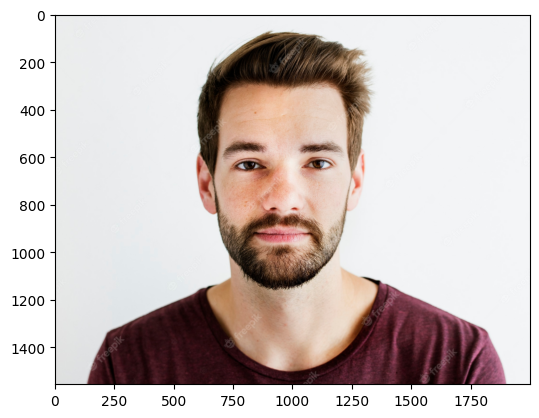

In [5]:
plt.imshow(imageArray)

## As the mathmatics for FFT of problem having number of samples not equal to 2<sup>n</sup> is complex. Also, Cooley-Tukey algorithm only gives the solution for problem having number of samples 2<sup>n</sup>. So, changing the given image array into 2<sup>n</sup> samples by adding null values

In [6]:
def correction(var):
    return int(math.pow(2,math.ceil(math.log2(var))))-var

crtImgArr = np.zeros(((x+correction(x)),(y+correction(y)),3),dtype=int)

for i in range((x+correction(x))):
    if(not((i<math.ceil(correction(x)/2))or(i>x+math.floor(correction(x)/2)-1))):
        crtImgArr[i,math.ceil(correction(y)/2):math.ceil(y+(correction(y)/2))]=imageArray[i-math.ceil(correction(x)/2)]

## The updated image.

Size of image is now:  (2048, 2048, 3)


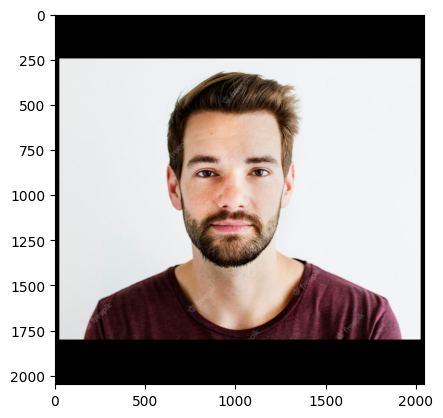

In [7]:
print("Size of image is now: ",crtImgArr.shape)
plt.imshow(crtImgArr)

## FFT Algorithm

In [9]:
@njit()
def cooley_tukey_fft(x: np.ndarray) -> np.ndarray:
    n = len(x)

    if n == 1:
        return np.asarray(x, dtype=np.complex128)

    # Split the input sequence into even and odd-indexed sub-sequences
    x_even = x[::2]
    x_odd = x[1::2]

    # Recursively compute the FFT of each sub-sequence
    y_even = cooley_tukey_fft(x_even)
    y_odd = cooley_tukey_fft(x_odd)

    # Combine the results
    y = np.zeros(n, dtype=np.complex128)
    for k in range(n//2):
        y_even_k = y_even[k]
        y_odd_k = y_odd[k]
        twiddle_factor = np.exp(-2j * np.pi * k / n)
        y[k] = y_even_k + twiddle_factor * y_odd_k
        y[k + n//2] = y_even_k - twiddle_factor * y_odd_k

    return y

@njit()
def custom_fft(img, height, width, axis):
    """
    if axis = 0, row is ffted, if axis = 1, column is ffted
    """
    _range = width if not axis else height

    trans = np.zeros((height,width),dtype=np.complex128)
    for i in range(_range):
        if axis==1:
            trans[:, i] = cooley_tukey_fft(img[:,i])
        else:
            trans[i, :] = cooley_tukey_fft(img[i,:])

    return trans

@njit()
def custom_fft2(img: np.ndarray, height: int, width: int) -> np.ndarray:
    """Two dimensional fft, first row wise then column wise"""
    transform = np.asarray(img, dtype=np.complex128)
    for i in range(2):
        transform = custom_fft(transform, height, width, i)

    return transform

@njit()
def custom_fft2_multichannel(img: np.ndarray) -> np.ndarray:
    transformed_multi_channel = np.zeros(img.shape, dtype=np.complex128)

    for channel in range(transformed_multi_channel.shape[2]):
        transformed_multi_channel[:, :, channel] = custom_fft2(img[:, :, channel], img.shape[0], img.shape[1])

    return transformed_multi_channel


## Finding the Fast Fourier Transform of image with multiiple channels.

In [10]:
transformed_img = custom_fft2_multichannel(crtImgArr)

## Compressing the image

In [11]:
@njit()
def discard_less_important(img: np.ndarray, threshold) -> np.ndarray:
    """The `threshold` is the values to discard 
    
    i.e. if `threshold`=90 then 90% of less magnitude coefficients are discarded """

    # for removing the undesired coefficients
    sorted_coefficients: np.ndarray = np.sort(np.abs(img.flatten()))

    # since the array is sorted, we can work on that position
    threshold_index = int((threshold) * sorted_coefficients.shape[0])  # keep value
    threshold_value = sorted_coefficients[threshold_index]

    # creating a sort of mask to filter out the values less than the threshold
    mask = np.abs(img) > threshold_value
    new_coefficients = img * mask

    return new_coefficients

@njit()
def discard_less_important_multi_channel(img, threshold):
    
    new_coefficients = np.zeros(img.shape, dtype=np.complex128)

    for channel in range(new_coefficients.shape[2]):
        new_coefficients[:, :, channel] = discard_less_important(img[:, :, channel], threshold)

    return new_coefficients


compression_threshold = 0.9
new_coefficients: np.ndarray = discard_less_important_multi_channel(transformed_img, compression_threshold)

## Plotting the fourier transforms before and after discarding some values

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'After Compression (Log Scale)')

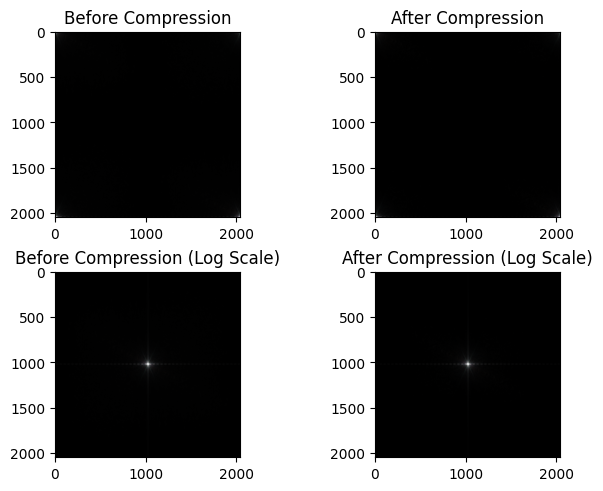

In [12]:
# Representing transforms in single image

normalize = True
normalization_factor = 255 / np.max(transformed_img)

# normalizing the original transforms, as there are many high values
normalized_transform = (transformed_img * normalization_factor) if normalize else transformed_img

# similarly
normalized_new_coefficients = (new_coefficients * normalization_factor) if normalize else new_coefficients

log_shifted_old_coefficients = np.zeros(normalized_transform.shape, dtype=np.float64)
log_shifted_new_coefficients = np.zeros(normalized_new_coefficients.shape, dtype=np.float64)

for channel in range(log_shifted_old_coefficients.shape[2]):
    log_shifted_old_coefficients[:, :, channel] = np.log(np.abs(np.fft.fftshift(normalized_transform[:, :, channel])) + 1)

for channel in range(log_shifted_new_coefficients.shape[2]):
    log_shifted_new_coefficients[:, :, channel] = np.log(np.abs(np.fft.fftshift(normalized_new_coefficients[:, :, channel])) + 1)

# the grid 
_, axis_arr = plt.subplots(2, 2, constrained_layout = True)

 # before compression
axis_arr[0, 0].imshow(np.abs(normalized_transform))
axis_arr[0, 0].set_title("Before Compression")

# after compression
axis_arr[0, 1].imshow(np.abs(normalized_new_coefficients))
axis_arr[0, 1].set_title("After Compression")

 # before compression log scale and shifted
axis_arr[1, 0].imshow(log_shifted_old_coefficients)
axis_arr[1, 0].set_title("Before Compression (Log Scale)")

# after compression log scale and shifted
axis_arr[1, 1].imshow(log_shifted_new_coefficients)
axis_arr[1, 1].set_title("After Compression (Log Scale)")




## Inverse FFT Algorithm

In [13]:
@njit()
def cooley_tukey_ifft(x: np.ndarray) -> np.ndarray:
    n = len(x)

    if n == 1:
        return np.asarray(x, dtype=np.complex128)

    # Split the input sequence into even and odd-indexed sub-sequences
    x_even = x[::2]
    x_odd = x[1::2]

    # Recursively compute the IFFT of each sub-sequence
    y_even = cooley_tukey_ifft(x_even)
    y_odd = cooley_tukey_ifft(x_odd)

    # Combine the results
    y = np.zeros(n, dtype=np.complex128)
    for k in range(n//2):
        y_even_k = y_even[k]
        y_odd_k = y_odd[k]
        twiddle_factor = np.exp(2j * np.pi * k / n)
        y[k] = y_even_k + twiddle_factor * y_odd_k
        y[k + n//2] = y_even_k - twiddle_factor * y_odd_k

    return y/n

@njit()
def custom_ifft(trans, height, width, dtype, axis):
    """row: axis = 0, column: axis = 1"""
    _range = width if not axis else height

    itrans = np.zeros((height,width),dtype=dtype)
    for i in range(_range):
        if axis==1:
            itrans[:, i] = cooley_tukey_ifft(trans[:,i])
        else:
            itrans[i, :] = cooley_tukey_ifft(trans[i,:])

    return itrans

@njit()
def custom_ifft2(trans: np.ndarray, height: int, width: int) -> np.ndarray:
    """Two dimensional ifft, first row wise then column wise"""
    itransform = np.asarray(trans, dtype=np.complex128)
    for i in range(2):
        itransform = custom_ifft(itransform, height, width, dtype=np.complex128, axis=i)

    return itransform

@njit()
def custom_ifft2_multichannel(trans_2d: np.ndarray) -> np.ndarray:
    inverse_transformed_multi_channel = np.zeros(trans_2d.shape, dtype=np.complex128)

    for channel in range(inverse_transformed_multi_channel.shape[2]):
        inverse_transformed_multi_channel[:, :, channel] = custom_ifft2(trans_2d[:, :, channel], trans_2d.shape[0], trans_2d.shape[1])
    return inverse_transformed_multi_channel


## Converting back to the image from the transform.

In [14]:
compressed_img = custom_ifft2_multichannel(new_coefficients)

### Converting back to unit8 image

In [19]:
compressed_img = (compressed_img/np.max(compressed_img) * 255).real.astype(np.uint8)

## Comparing images side by side

Text(0.5, 1.0, 'Compressed Image [90%]')

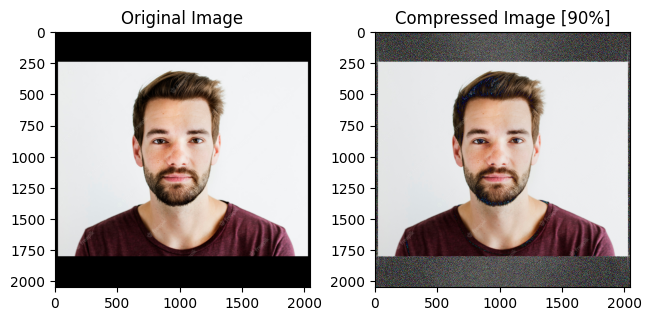

In [20]:

# the grid
_, axis_arr = plt.subplots(1, 2, constrained_layout = True)

# in normal scale

# before compression
axis_arr[0].imshow(crtImgArr)
axis_arr[0].set_title("Original Image")

# after compression
axis_arr[1].imshow(compressed_img.astype(np.uint8))
axis_arr[1].set_title(f"Compressed Image [{(compression_threshold * 100):.0f}%]")
